In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pareto
import random
import functions as f

```import functions as f``` : imports the package where we defined all of our functions

In [2]:
#GLOBAL CONSTANTS
clv_theory = 10 
size= 10000 # size of each sample
n = 10000 # number of samples
DureeObs = 12*2 # duration of observation

## Exponential (not censored)

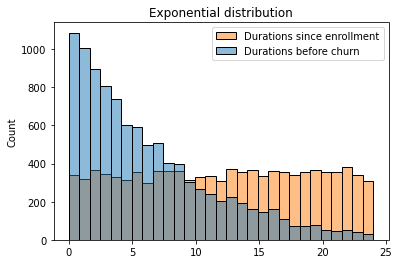

In [3]:
sns.histplot( f.generate_exponential(clv_theory, size,DureeObs)).set(title="Exponential distribution")
plt.legend(['Durations since enrollment','Durations before churn'])
plt.show()

**CLV computing**

In [4]:
# CONSTANT
censored = 0
# Monte Carlo simulation
clv_exp_nc, Y_n = f.monte_carlo(clv_theory, size, n, censored, f.exp_nc_clv_estimator, f.generate_nc_exponential)

CONVERGENCE :
 	 size of each dataset =10000 
 	 number of datasets =10000 
 	 CLV thoery = 10.00 
 	 CLV real = 10.000304  
 	 Standard deviation CLV= 0.099888


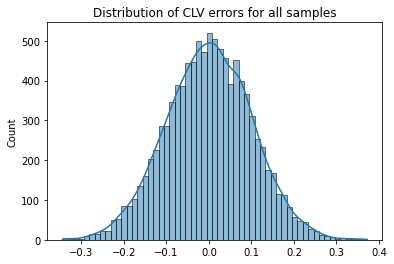

In [5]:
f.print_conv_plot_distribution(size, n ,clv_theory, clv_exp_nc)

Thanks to this plot, we can see in practice the convergence of the estimator.

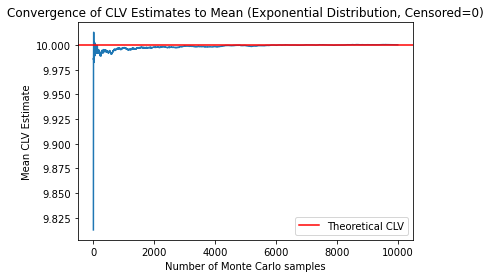

In [6]:
f.clv_convergence(clv_exp_nc, clv_theory,n , 'Convergence of CLV Estimates to Mean (Exponential Distribution, Censored=0)')

**Confidence interval - Monte Carlo**

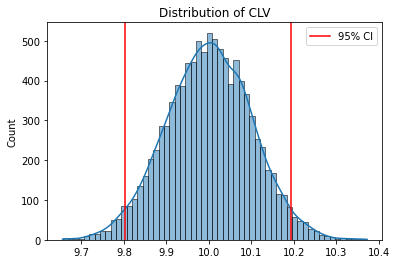

IC = [9.802738 , 10.193417 ] 


In [7]:
lower_exp_nc, upper_exp_nc = f.CI_plot_95(clv_exp_nc, 0.05)

95% of the CLV values of the all the Monte Carlo samples are within this confidence interval.

## Exponential (censored)

**CLV computing**

In [11]:
# CONSTANT
censored = 1
# Monte Carlo simulation
clv_exp_c, Y_n =f. monte_carlo(clv_theory, size, n, censored, f.exp_c_clv_estimator, f.generate_exponential)

CONVERGENCE :
 	 size of each dataset =10000 
 	 number of datasets =10000 
 	 CLV thoery = 10.00 
 	 CLV real = 9.998990  
 	 Standard deviation CLV= 0.126276


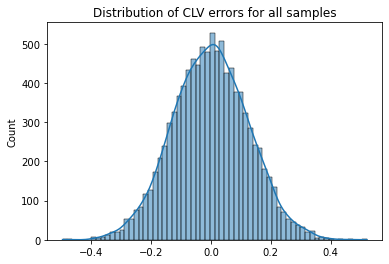

In [12]:
f.print_conv_plot_distribution(size, n ,clv_theory, clv_exp_c)

The error is still normally distributed and the standart deviation is higher. 
As censored data are normally distributed, they have no impact on the error distribution. Censored data increase the std of the error by 40% comparing to non censored data.

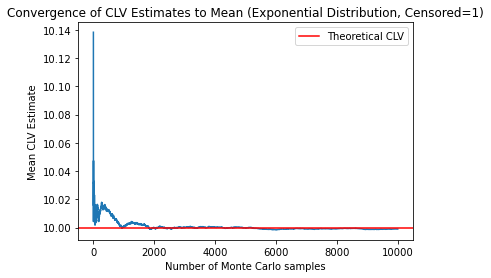

In [13]:
f.clv_convergence(clv_exp_c, clv_theory,n , 'Convergence of CLV Estimates to Mean (Exponential Distribution, Censored=1)')

**Theoretical confidence intervals**

In [14]:
lower_exp_c = []
upper_exp_c = []
for i in range(n):
    lower_exp_c.append(f.CI_exp_c_clv(1.96, Y_n[i][0], Y_n[i][1])[0])
    upper_exp_c.append(f.CI_exp_c_clv(1.96, Y_n[i][0], Y_n[i][1])[1])

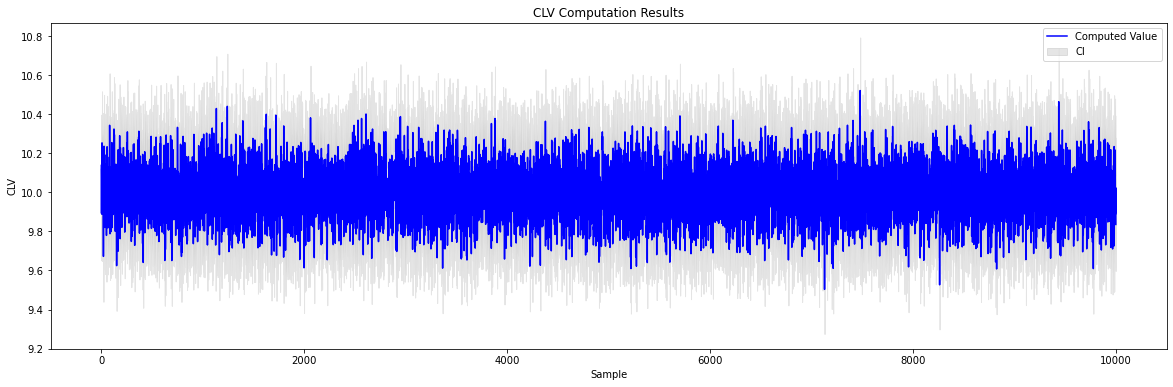

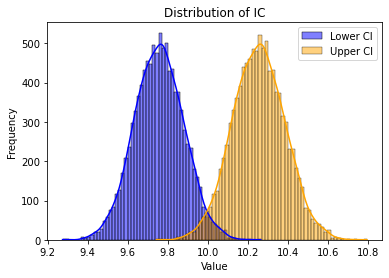

Theoritical_CI = [9.756347088619624, 10.254010991885144 ]. 
 CONFIDENCE LEVEL: 94.98% of estimators are within this interval


In [15]:
# plot confidence interval
f.CI_multiplot(clv_exp_c, lower_exp_c, upper_exp_c)

Using the Monte Carlo method to estimate confidence intervals is an efficient approach to test the theoretical formula, as it often yields similar results to those obtained using theoretical formulas. In fact, the average confidence interval estimated using Monte Carlo simulations tends to the one calculated using theoretical formulas. So, to check the confidence level, we compute the clv values of the n samples (generated with Monte Carlo simulation) and then check if 95% are within it. As we can see after the plots, 95.33% of clv valus are inside the theoretical confidence interval. Hence, the validation of the confidence interval calculted in theory.

**Bootstrap confidence intervals**

Although the confidence intervals have been calculated using the theoretical formula, the purpose of this section is to verify the results using the bootstrap method.

In [17]:
# GENERATE one sample to study the effect of boostrapping
Y_n =[]
T, A = f.generate_exponential(clv_theory, size, DureeObs)
Y_n.append(T)
Y_n.append(A)

In [25]:
lower_exp_ct , upper_exp_ct = f.CI_exp_c_clv(1.96, T, A)
print("IC theory = [%f,%f]"%(lower_exp_ct,upper_exp_ct))

IC theory = [9.670378,10.162190]


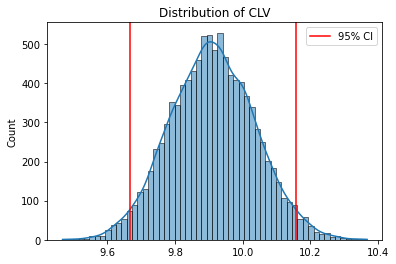

IC = [9.667904 , 10.157543 ] 


In [23]:
_,_ , clv_exp_cb = f.bootstrap_samples(Y_n, censored, f.exp_c_clv_estimator)
lower_exp_cb, upper_exp_cb  = f.CI_plot_95(clv_exp_cb, 0.05)

In [35]:
print("Bootstrapping method IC lower bound is %.3f %% different from the theoretical IC lower bound."%(round(100*abs(lower_exp_cb-lower_exp_ct)/lower_exp_cb,3)))
print("Bootstrapping method IC upper bound is %.3f %% different from the theoretical IC upper bound."%(round(100*abs(upper_exp_cb-upper_exp_ct)/upper_exp_cb,3)))

Bootstrapping method IC lower bound is 0.026 % different from the theoretical IC lower bound.
Bootstrapping method IC upper bound is 0.046 % different from the theoretical IC upper bound.


As we can see the bootstrapping method has less than 0.05% of error comparing to the theoretical bounds. So we can clearly conclude that when we cannot find and compute the formula of the confidence interval (which is commonly the case in practice since we don't know exactly the distribution of the data), the bootstrapping method can be a good solution.

# Finding the best n